In [2]:
import csv
import linecache
import datetime
import sys
import numpy as np
import random
from scipy.sparse import *
from scipy import *
import scipy as sp
import matplotlib.pyplot as plt
import os.path
import matplotlib
import copy
import pandas as pd
from scipy import stats
from tempfile import TemporaryFile
import pickle
from scipy.integrate import odeint
# from torchdiffeq import odeint as dodeint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from scipy.stats import skew
from scipy.optimize import minimize

In [3]:
# define a convinent print function that can output the string at the same line repeatly.
def flushPrint(variable):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % variable)
    sys.stdout.flush() 

# import data

In [4]:
## import pij
pij = np.loadtxt('./new_data/pij.csv', delimiter=',')

In [5]:
## import country data
df=pd.read_csv('./new_data/case_dataset.csv', encoding='gbk', sep='\t')
df.drop_duplicates(subset=['country'], keep='first', inplace=True)  # 根据'country'列去重
nodes = {}  # 格式形如：{'United Arab Emirates': 0, 'Australia': 1, ...}
country_properties = {}  # 格式形如：{'United Arab Emirates': {'pop': 9890402}, 'Australia': {'pop': 25499884}, ...}
pop_list = list(df['population'])
for idx, ct in enumerate(list(df['country'])):
    nodes[ct] = len(nodes)
    country_properties[ct] = {'pop': pop_list[idx]}
print(nodes)
print(country_properties)

{'United Arab Emirates': 0, 'Australia': 1, 'Brazil': 2, 'Germany': 3, 'Russia': 4, 'France': 5, 'Philippines': 6, 'Korea, South': 7, 'Netherlands': 8, 'Canada': 9, 'Malaysia': 10, 'US': 11, 'Mexico': 12, 'Japan': 13, 'Thailand': 14, 'Turkey': 15, 'Spain': 16, 'Hong Kong(China)': 17, 'Singapore': 18, 'India': 19, 'Indonesia': 20, 'United Kingdom': 21, 'Vietnam': 22, 'China': 23}
{'United Arab Emirates': {'pop': 9890402}, 'Australia': {'pop': 25499884}, 'Brazil': {'pop': 212559417}, 'Germany': {'pop': 83783942}, 'Russia': {'pop': 145934462}, 'France': {'pop': 65273511}, 'Philippines': {'pop': 109581078}, 'Korea, South': {'pop': 51269185}, 'Netherlands': {'pop': 17134872}, 'Canada': {'pop': 37742154}, 'Malaysia': {'pop': 32365999}, 'US': {'pop': 331002651}, 'Mexico': {'pop': 128932753}, 'Japan': {'pop': 126476461}, 'Thailand': {'pop': 69799978}, 'Turkey': {'pop': 84339067}, 'Spain': {'pop': 46754778}, 'Hong Kong(China)': {'pop': 7547652}, 'Singapore': {'pop': 5850342}, 'India': {'pop': 1

In [6]:
## 做一些数据统计
df=pd.read_csv('./new_data/case_dataset.csv', encoding='gbk', sep='\t')
df.drop_duplicates(subset=['date'], keep='first', inplace=True)  # 根据'date'列去重
t_days = len(df['date'])

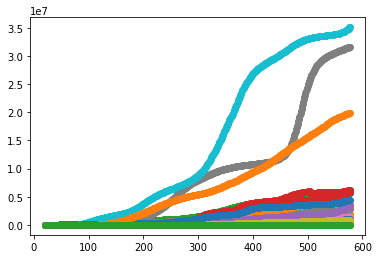

(array([ 21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
        60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 2

In [7]:
## import case data
df = pd.read_csv('./new_data/case_dataset.csv', encoding='gbk', sep='\t')

all_cases_countries = list(set(df['country']))[1:]

China=df.loc[df['country']=='China',['confirmed','date','recovered','death']]
dates = list(China['date'])
sorted_dates = np.sort(dates)
first_date = datetime.datetime(2020, 1, 1, 0, 0)
first_cases = int(China.loc[China['date']=='2020-01-22']['confirmed'])

all_cases = {}  # 其每个key对应一个城市，每个key的value是一个tuple，包含日期序号、confirmed数、recovered数、death数
for country in all_cases_countries:
    subset = df.loc[df['country']==country, ['confirmed','date','recovered','death']]
    new_cases = np.array(subset['confirmed'])
    cued_cases = np.array(subset['recovered'])
    die_cases = np.array(subset['death'])
    dates = list(subset['date'])
    days = []
    for i,dd in enumerate(dates):
        if not pd.isnull(dd):
            days.append((datetime.datetime.strptime(dd,'%Y-%m-%d') - first_date).days)
    sorted_days = np.sort(days)
    indx = np.argsort(days)
    infected = new_cases[indx]
    cued = cued_cases[indx]
    death = die_cases[indx]
    bools = sorted_days>=0
    if len(sorted_days)>0:
        all_cases[country] = (sorted_days[bools], infected[bools], cued[bools], death[bools])

for case in all_cases.values():
    xx = case[0]
    yy = case[1]
    if len(yy) > 0:
        plt.plot(xx, yy, 'o-')
#plt.semilogy()
plt.show()

print(all_cases['Thailand'])

# Define the ODE model
The model can be described by:

$\partial i_n/\partial t = \frac{R_0}{T_L}i_n s_n - \frac{1}{T_L}i_n + \gamma \sum_{m\neq n}p_{nm}(i_m-i_n)$


$\partial c_n/\partial t = \frac{\alpha}{T_L} c_n - \frac{1}{T_I} c_n$



$\partial s_n/\partial t = -\frac{R_0}{T_L} i_n s_n + \gamma \sum_{m\neq n}p_{nm}(s_m-s_n)$


$r_n = 1 - s_n - j_n - l_n$

where $i_n$ is infection ratio of city n; 
$s_n$ is the susceptible ratio of city n; 
$c_n$ is the confirmed ratio of city n; 
$R_0$ is the basic reproductive number；
$T_I$ is the average time from confirmed to cure / death; 
$T_L$ is the average time from infected to confirm; 
$\gamma$ is the average ratio of migration population to the total population；
$p_{nm}$ is the migration ratio from city n to city m.

In our simulation, we use matrix and inner product to compute $\sum_{m\neq n}p_{nm}(x_m-x_n)$, also with some simplification, i.e., $\sum_{m\neq n}p_{nm}(x_m-x_n)=\sum_m p_{nm}x_m-x_n$ be $P\cdot \vec{x} - \vec{x}$, where $x$ is $l,j,s$, $\vec{x}=(x_1,x_2,...,x_N)$

In [8]:
# 不用可微分求解
def protect_decay(t, t0, eta, rate_time, relax):
    epsilon = 0.001
    r = 2 * np.log((1-epsilon)/epsilon) / rate_time
    x0 = t0 + rate_time/2
    decay = eta / (1 + np.exp(r * (t - x0))) + 1 - eta
    if relax>0:
        #tstar = x0 + np.log((1-relax*epsilon)/(relax*epsilon+eta-1))
        tstar = relax
        decay1 = eta/(1 + np.exp(r*(2*tstar - t - x0))) + 1 - eta
        decay = decay + decay1
    return decay

def diff(y0, t, r_0, T_R, T_L, alpha, omega, eta, rate_time, protect_day, pijt, intervention, relax=0):
    """
    ode术语：这里的y0是所有ode的f(t)。
    这里把所有ode拆成4部分（每部分的数目是state_num），取前3部分得到：文章Fig. 2的In, Cn, Sn。
    
    alpha: 标量，改成含state_num个元素的向量
    omega: 标量
    eta: 标量
    rate_time: 标量
    protect_day: 标量
    intervention: bool
    T_R: 一个标量
    T_L: 一个标量
    pijt: 一个state_num * state_num的矩阵。
    
    其中r_0和alpha是待定系数，由拟合得到。
    In由待定系数initial_latent得到。
    其余量均给定。
    
    """
    #sicol: 感染，确诊，易感
    state_num = y0.shape[0] // 4
    In = y0[:state_num]  # 感染
    Cn = y0[state_num: 2 * state_num]  # 确诊
    Sn = y0[2 * state_num: 3 * state_num]  # 易感
    lterm = pijt.dot(In) - In
    jterm = pijt.dot(Cn) - Cn
    sterm = pijt.dot(Sn) - Sn
    cross_term = r_0  * In * Sn / T_L
    if intervention:
        cross_term = cross_term * protect_decay(t, protect_day, eta, rate_time, relax)
        
    delta_l = cross_term - In / T_L + omega * lterm
    delta_j = alpha * In / T_L - Cn / T_R #+ omega * jterm
    delta_s = - cross_term + omega * sterm
    
    cum_inf_conf = cross_term #infected
    #cum_inf_conf = alpha * In / T_L # confirmed
    
    output = np.r_[delta_l, delta_j, delta_s, cum_inf_conf]  # 把delta_l等按列拼合，使得output的shape与input的t的shape对应。
    return output

## 尝试调用

In [129]:
# 参数设定
steps = 1000
eta = 1

scenarios = {'no_inter':[35,22,False], \
             'baseline':[35,22,True], \
             'early':[35,12,True],\
             'severe':[70,22,True],\
             'new':[28, 22, True],\
             'early_slow':[70, 12, True]
            }
t_m, t_0, interQ = scenarios['early_slow']

# 模拟待定参数的求解结果：
r0=2.21
initial_latent=390
alpha=0.90
# alpha = np.array([0.9]*len(nodes))

# 模拟对应的T_R, T_L, omega
T_R = np.random.randn() * 0.9 / 1.96 + 9.2  # serial interval，参考SARS
T_L = np.random.randn() * 0.4 / 1.96 + 8.3  # 一个病患潜伏期时间，参考SARS、MERS
omega = np.random.randn() * 0.008 + 0.03

timespan = np.linspace(0, t_days, steps)  # steps=1000, t_days=300
inter = timespan[1]-timespan[0]
Is0 = np.zeros(len(nodes))
Cs0 = np.zeros(len(nodes))
Ss0 = np.ones(len(nodes))
Is0[nodes['China']] = float(initial_latent)/float(country_properties['China']['pop'])  # 1e-4
Cs0[nodes['China']] = float(first_cases)/float(country_properties['China']['pop'])
Ss0[nodes['China']] = 1 - Is0[nodes['China']] - Cs0[nodes['China']]

cum_inf_conf = np.zeros(len(nodes))

# ode术语：y0 = y(t[0]) = np.r_[Is0, Cs0,Ss0, cum_inf_conf]，t = timespan
y0 = np.r_[Is0, Cs0, Ss0, cum_inf_conf]
print(timespan.shape)
print(y0.shape)
result = odeint(diff, np.r_[Is0, Cs0, Ss0, cum_inf_conf], timespan, args = (r0, T_R, T_L, alpha, omega, eta, t_m, t_0, pij, interQ, 100))
# print(result)
# print(result.shape)


(1000,)
(96,)


# 划分训练集、测试集

In [9]:
seperate = {'first': {'start': 0, 'end': 120}}

def create_train_test_dataset(choose_key):
    indices = list(range(seperate[choose_key]['start'], seperate[choose_key]['end']))  # 获取索引
    indices_train = indices[: 8 * (len(indices) // 10)]
    indices_test = indices[8 * (len(indices) // 10):]
    all_cases_train = {}
    all_cases_test = {}
    # 回顾 all_cases ，其每个key对应一个城市，每个key的value是一个tuple，包含日期序号、confirmed数、recovered数、death数
    for country in all_cases_countries:
        all_cases_train[country] = (all_cases[country][0][indices_train], 
                                    all_cases[country][1][indices_train], 
                                    all_cases[country][2][indices_train], 
                                    all_cases[country][3][indices_train])
        all_cases_test[country]  = (all_cases[country][0][indices_test], 
                                    all_cases[country][1][indices_test], 
                                    all_cases[country][2][indices_test], 
                                    all_cases[country][3][indices_test])
    train_data_num = len(all_cases_train['China'][0])
    test_data_num = len(all_cases_test['China'][0])
    return all_cases_train, all_cases_test, train_data_num, test_data_num

In [10]:
choose_key = 'first'
all_cases_train, all_cases_test, train_data_num, test_data_num = create_train_test_dataset(choose_key)

In [18]:
len(all_cases_train['China'][0])

96

# 求解待定系数

In [15]:
def params_regression(all_cases_train, T_R, T_L, omega, 
                      train_data_num, eta, t_m, t_0, interQ):
    
    # 计算需要的参数
    t_days = len(all_cases_train['China'][0])
    target = np.zeros((train_data_num, len(nodes)))
    for idx, country in enumerate(all_cases_countries):
        target[:, idx] = all_cases_train[country][1]
    populations = [item['pop'] for item in country_properties.values()]
    global prediction
    
    # 定义目标函数
    def objective_func(x):
        global prediction
        r0 = x[0]
        initial_latent = x[1]
        # alpha = x[2]
        alpha = x[2:]
        timespan = np.linspace(0, t_days-1, train_data_num)
        In0 = np.zeros(len(nodes))
        Cn0 = np.zeros(len(nodes))
        Sn0 = np.ones(len(nodes))
        In0[nodes['China']] = float(initial_latent)/float(country_properties['China']['pop'])  # 1e-4
        Cn0[nodes['China']] = float(first_cases)/float(country_properties['China']['pop'])
        Sn0[nodes['China']] = 1 - In0[nodes['China']] - Cn0[nodes['China']]
        cum_inf_conf = np.zeros(len(nodes))
        # ode术语：y0 = y(t[0]) = np.r_[In0, Cn0, Sn0, cum_inf_conf]，t = timespan
        y0 = np.r_[In0, Cn0, Sn0, cum_inf_conf]
        prediction = odeint(diff, y0, timespan, args = (r0, T_R, T_L, alpha, omega, eta, t_m, t_0, pij, interQ, 100))
        # 取出cn
        cn = prediction[:, len(nodes): 2*len(nodes)]
        # 计算优化目标
        # loss = np.sum((np.log10(cn * populations + 1e-6) - np.log10(target + 1e-6))**2)
        loss = np.mean((np.log10(cn * populations + 1e-6) - np.log10(target + 1e-6))**2)
        return loss
    
    # 定义边界条件
    bounds = [(1, 4), (0, None)] + [(0, 1) for _ in range(len(nodes))]
    
    # initial solutions
    params0 = np.array([2.21, 390] + [0.8] * len(nodes))  # 包含r0, initial_latent, alpha
    
    # 求解
    res = minimize(objective_func, params0, method='SLSQP', bounds=bounds, options={'disp': True})
    params = res.x
    # print(params)
    r0 = params[0]
    initial_latent = params[1]
    alpha = params[2:]
    # print('r0: ', r0)
    # print('initial_latent: ', initial_latent)
    # print('alpha: ', alpha)
    return r0, initial_latent, alpha, prediction

def experiment(all_cases_train, all_cases_test, train_data_num, eta, t_m, t_0, interQ, exp_num=1):
    """
    传入参数:
    all_cases_train: 训练集
    all_cases_test: 测试集
    exp_num: 重复实验的次数
    """
    result = {}  # 存储结果的字典
    result_list = []  # 存储所有的结果
    for exp_idx in range(exp_num):
        # 模拟一组T_R, T_L, omega
        T_R = np.random.randn() * 0.9 / 1.96 + 9.2  # serial interval，参考SARS
        T_L = np.random.randn() * 0.4 / 1.96 + 8.3  # 一个病患潜伏期时间，参考SARS、MERS
        omega = np.random.randn() * 0.008 + 0.03
        result['T_R'] = T_R
        result['T_L'] = T_L
        result['omega'] = omega
        # 求解r0, initial_latent, alpha
        r0, initial_latent, alpha, prediction = params_regression(all_cases_train, T_R, T_L, omega, 
                                                                  train_data_num, eta, t_m, t_0, interQ)
        result['r0'] = r0
        result['initial_latent'] = initial_latent
        result['alpha'] = alpha
        result['prediction'] = prediction
        result_list.append(result)
    return result_list

Optimization terminated successfully    (Exit mode 0)
            Current function value: 10.727924834425806
            Iterations: 10
            Function evaluations: 163
            Gradient evaluations: 6


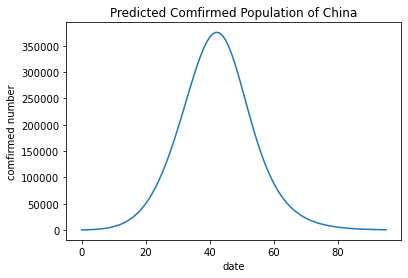

In [30]:
# 参数设定
eta = 1

# control
scenarios = {'no_inter':[35,22,False], \
             'baseline':[35,22,True], \
             'early':[35,12,True],\
             'severe':[70,22,True],\
             'new':[28, 22, True],\
             'early_slow':[70, 12, True]
            }

t_m, t_0, interQ = scenarios['early_slow']

# 执行实验
result_list = experiment(all_cases_train, all_cases_test, train_data_num, eta, t_m, t_0, interQ, exp_num=1)

# 画图
plt.figure()
for result in result_list:
    prediction = result['prediction']
    country = 'China'
    i = nodes[country]
    confirmed_values = prediction[:, i] * country_properties[country]['pop']
    t = list(range(len(confirmed_values)))
    plt.plot(t, confirmed_values, label=country)
    plt.title('Predicted Comfirmed Population of '+country)
    plt.xlabel('date')
    plt.ylabel('comfirmed number')
plt.show()


In [34]:
np.log10(13579482377163.281)

13.132883215818849